In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [17]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/IA/Investigacion /EMG/emg_features_optimized.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Separar características y etiquetas
X = df.drop('Cluster', axis=1).values
y = df['Cluster'].values

In [19]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Reshape para LSTM: (n_samples, time_steps, features)
# Aquí tratamos cada muestra como una "secuencia de 6 pasos, 1 feature"
X_seq = X_scaled.reshape(-1, 3, 1)

In [21]:
# Aquí se podrían añadir pasos adicionales de preprocesamiento si fueran necesarios antes de dividir los datos.

In [22]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.3, random_state=1601, shuffle=True)

In [23]:
# Construcción del modelo LSTM
model = Sequential([
    LSTM(64, input_shape=(6, 1), return_sequences=False),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # salida binaria
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Compilación
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
# Entrenamiento
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.9867 - loss: 0.0524 - val_accuracy: 0.9987 - val_loss: 0.0030
Epoch 2/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9979 - loss: 0.0049 - val_accuracy: 0.9990 - val_loss: 0.0025
Epoch 3/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9982 - loss: 0.0043 - val_accuracy: 0.9989 - val_loss: 0.0027
Epoch 4/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9983 - loss: 0.0040 - val_accuracy: 0.9996 - val_loss: 0.0018
Epoch 5/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9985 - loss: 0.0039 - val_accuracy: 0.9989 - val_loss: 0.0023
Epoch 6/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9985 - loss: 0.0033 - val_accuracy: 0.9989 - val_loss: 0.0025
Epoch 7/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9985 - loss: 0.0036 - val_accuracy: 0.9995 - val_loss: 0.0016
Epoch 8/20
5163/5163 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9987 - loss: 0

4426/4426 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
4426/4426 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


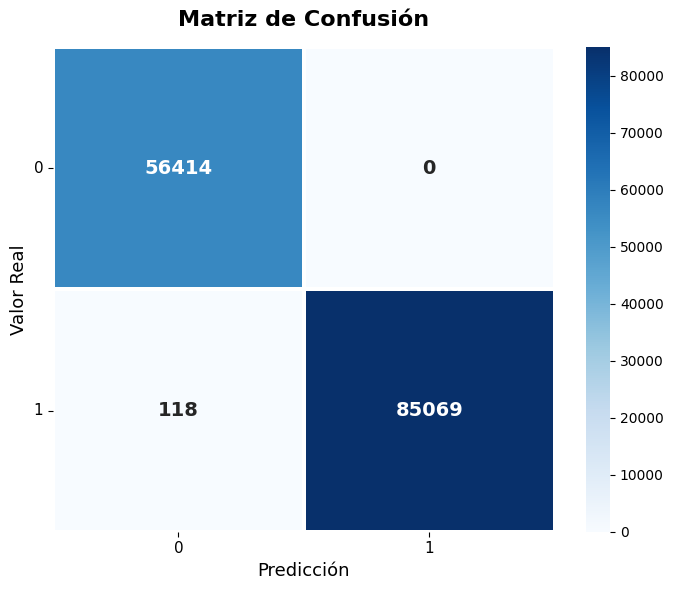

              precision    recall  f1-score   support

           0     0.9979    1.0000    0.9990     56414
           1     1.0000    0.9986    0.9993     85187

    accuracy                         0.9992    141601
   macro avg     0.9990    0.9993    0.9991    141601
weighted avg     0.9992    0.9992    0.9992    141601



In [30]:
# Evaluar
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib.pyplot


# Generar predicciones
Predicciones_prob = model.predict(X_test)
Predicciones = (Predicciones_prob > 0.5).astype("int32")

# Evaluar
Predicciones_prob = model.predict(X_test)
Predicciones = (Predicciones_prob > 0.5).astype("int32")

# --- Calcular matriz de confusión ---
cm = confusion_matrix(y_test, Predicciones)
labels = np.unique(y_test)  # etiquetas de clases detectadas

# --- Gráfica ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 14, "weight": "bold"}, cbar=True, linewidths=1.5)

# --- Estilo ---
plt.title('Matriz de Confusión', fontsize=16, pad=15, weight='bold')
plt.xlabel('Predicción', fontsize=13)
plt.ylabel('Valor Real', fontsize=13)

# Ajustes estéticos
plt.xticks(fontsize=11)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()

# Mostrar
plt.show()

print(classification_report(y_test, Predicciones, digits=4))



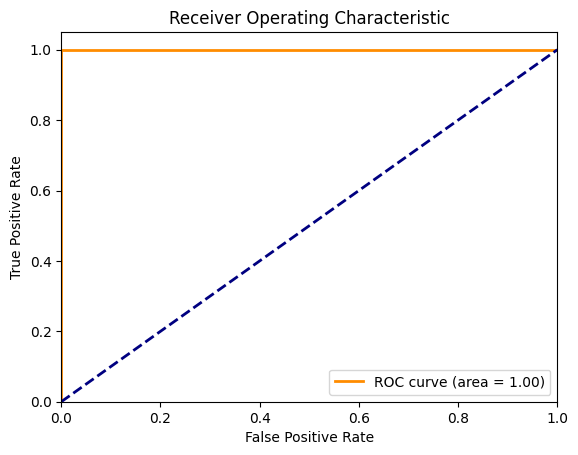

In [26]:
# prompt: generar curva roc

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, Predicciones_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [31]:
import tensorflow as tf

model_filename = '/content/drive/MyDrive/IA/Investigacion /EMG/LSTM/lstm_model.h5' # Use .h5 extension for Keras models

# Save the model
model.save(model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to /content/drive/MyDrive/IA/Investigacion /EMG/LSTM/lstm_model.h5


In [34]:
# --- Mediciones de eficiencia ---
import time
import psutil
import os

N_ITER = 100
tiempos = []
for _ in range(N_ITER):
    start = time.perf_counter()
    model.predict(X_test[:1])  # Inferencia por sample para mejor estimación
    end = time.perf_counter()
    tiempos.append(end - start)

print(f"Inference time (per sample): {np.mean(tiempos):.6f} ± {np.std(tiempos):.6f} seconds")

# Uso de RAM
process = psutil.Process(os.getpid())
ram_mb = process.memory_info().rss / (1024 ** 2)
print(f"RAM usage: {ram_mb:.6f} MB")

# Tamaño en disco
disk_mb = os.path.getsize(model_filename) / (1024 ** 2)
print(f"Model disk space: {disk_mb:.6f} MB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━